In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps
from serenityff.charge.gnn.attention_extraction.extractor import Extractor

sdf_file = "../data/example.sdf"
model_path = "../data/example_model.pt"
extraction_path = "extraction.csv"

In [4]:
Extractor.run_extraction_local(sdf_file=sdf_file, ml_model=model_path, epochs=50, output=extraction_path)

100%|██████████| 20/20 [00:00<00:00, 1010.13it/s]


In [7]:
df = pd.read_csv(extraction_path)

In [8]:
df.head(2)

,atomtype,smiles,idx_in_mol,mol_index,node_attentions,edge_attentions,prediction,truth
0,C,[H]c1nnc2c(n1)c(=O)n(C([H])([H])[H])c(=O)n2[H],0,0,"[0.39049386978149414, 0.41060370206832886, 0.4...","[0.3661991059780121, 0.38646918535232544, 0.69...",-0.191903,-0.2029
1,N,NaN,1,0,"[0.39372700452804565, 0.5482110977172852, 0.36...","[0.6742862462997437, 0.67062908411026, 0.65288...",-0.372856,-0.3875


In [40]:
atom_idx_to_draw = 2
mol_idx_to_draw = 0
attention_data_for_atom = eval(df[(df["idx_in_mol"] == atom_idx_to_draw) & (df["mol_index"] == mol_idx_to_draw)].iloc[0]["node_attentions"])
mol = Chem.SDMolSupplier(sdf_file, removeHs=False)[mol_idx_to_draw]
print(attention_data_for_atom)

[0.4097609519958496, 0.6152873635292053, 0.4981358051300049, 0.6138879656791687, 0.6187657117843628, 0.36736780405044556, 0.38269203901290894, 0.3396620452404022, 0.37030133605003357, 0.37413981556892395, 0.32944491505622864, 0.37475135922431946, 0.3861730098724365, 0.3846278786659241, 0.37548431754112244, 0.4163527488708496, 0.3814643323421478, 0.39142465591430664]


In [46]:
def normalize_attention(attention_data):
    return np.array(attention_data) / np.sum(attention_data)

In [47]:
attention_data_for_atom_normalized = normalize_attention(attention_data_for_atom)

In [70]:
# recalculate 2D coordinates for drawing
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)
# retrieve the 2d coordinates for the atom
atom_x, atom_y = mol._atomPs[atom_idx_to_draw]

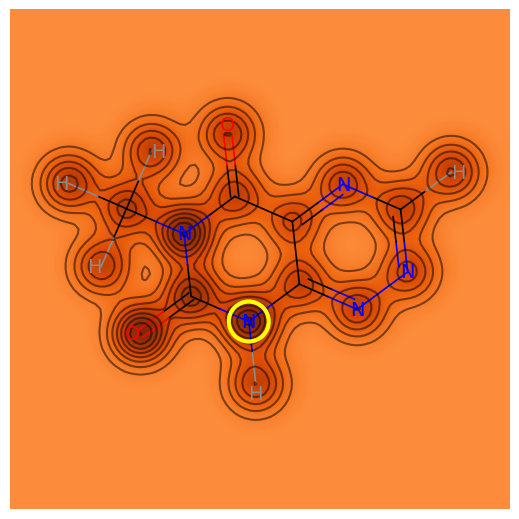

In [90]:
plot = SimilarityMaps.GetSimilarityMapFromWeights(mol=mol, 
                                           weights=attention_data_for_atom_normalized, 
                                           colorMap="Oranges", 
                                           contourLines=8, 
                                           size=(200, 200),)
# draw circle around atom of interest
plot.add_artist(plt.Circle((2.5*atom_x, 2.5*atom_y), radius=0.1, color="yellow", fill=False, linewidth=3))

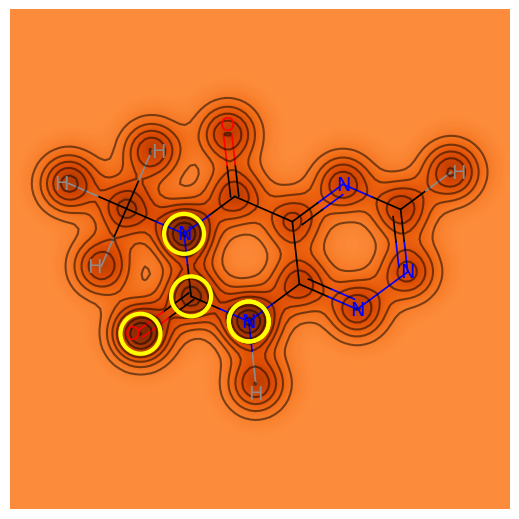

In [91]:
# 4 atoms with highest attention
top_4_atoms = np.argsort(attention_data_for_atom_normalized)[-4:]
for atom_idx in top_4_atoms:
    atom_x, atom_y = mol._atomPs[atom_idx]
    plot.add_artist(plt.Circle((2.5*atom_x, 2.5*atom_y), radius=0.1, color="yellow", fill=False, linewidth=3))
plot

In [92]:
os.remove("extraction.csv")